# SPARQL Test for Wikidata and DBpedia with LC-QuAD 2.0

In [ ]:
# import all the necessary libraries
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

## Get distinct template_ids
Extracting all distinct template_ids from the LC-QuAD 2.0 dataset. This is done to see if all template_ids are covered by the number of test queries/questions. Here it should also be seen if certain queries templates are not working at all, meaning there is not problem with updated information or something, but that the template type is not supported, by either of the endpoints (https://skynet.coypu.org/wikidata/; localhost:8890/sparql). 

In [43]:
# Load the LC-QuAD 2.0 dataset
url = "https://raw.githubusercontent.com/AskNowQA/LC-QuAD2.0/refs/heads/master/dataset/train.json"
response = requests.get(url)
lc_quad_data = response.json()

# Extract distinct template_id values from the full dataset
all_template_ids = {entry.get("template_id") for entry in lc_quad_data if "template_id" in entry}

# Extract distinct template_id values from the first 200 questions
first_200_template_ids = {entry.get("template_id") for entry in lc_quad_data[:200] if "template_id" in entry}

# Check if all distinct template_ids from the full dataset are included in the first 200 questions
missing_template_ids = all_template_ids - first_200_template_ids

# Output the results
print("All template_ids from the full dataset:", all_template_ids)
print("Template_ids in the first 200 questions:", first_200_template_ids)

if not missing_template_ids:
    print("All distinct template_ids are included in the first 200 questions.")
else:
    print(f"The following template_ids are missing in the first 200 questions: {missing_template_ids}")

All template_ids from the full dataset: {'Rank2', 1, '1.1', 2, 3, 5, '1.2', 4, 'statement_property_1', 'Rank1', '1', 'Count_1', 'Count_2', 'statement_property_2'}
Template_ids in the first 200 questions: {'Rank2', 1, '1.1', 2, 3, 5, '1.2', 4, 'statement_property_1', 'Rank1', '1', 'Count_1', 'Count_2', 'statement_property_2'}
All distinct template_ids are included in the first 200 questions.


As a result all distinct template_ids are included in the first 200 queries of the LC-QuAD 2.0 dataset.

## Querying Wikidata endpoint
Using the LC-QuAD 2.0 dataset to query the wikidata endpoint (https://skynet.coypu.org/wikidata/). This is done to see if the queries are working and if the endpoint is able to return results. The results should provide answers, those that return "No answer", and queries that fail for some reason (are not properly able to be executed by the endpoint).

In order to achive this the SPARQL queries are executed, sending them to the endpoint and then checking the results and visualizing them in a chart. Further the results are saved in a excel file to manually check the "no answer" queries and see if they also fail when executing them in the skynet web interface as well as in the wiki data query service (https://query.wikidata.org/), also in order to find patterns, e.g. certain template_ids always failing. 

Number of queries with proper answers: 127
Number of queries with no answers: 73
Number of failed queries: 0


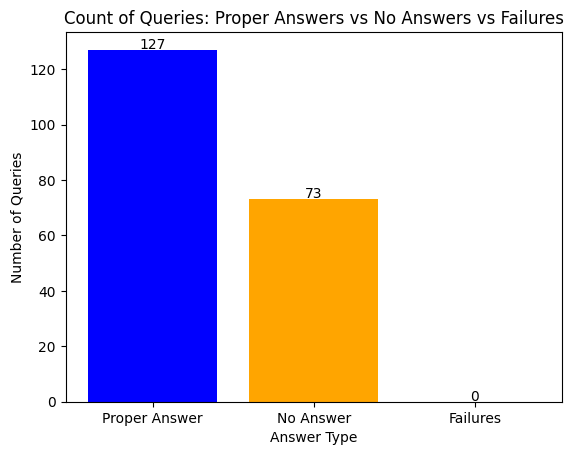

What periodical literature does Delta Air Lines use as a moutpiece?: Success, Answer: ['http://www.wikidata.org/entity/Q3486420']
Who is the child of Ranavalona I's husband?: Success, Answer: ['http://www.wikidata.org/entity/Q218622']
Is it true Jeff_Bridges occupation Lane Chandler and photographer ?: Success, Answer: ['False']
What is the pre-requisite of phase matter of Galinstan?: Success, Answer: ['No answer']
Which is the operating income for Qantas?: Success, Answer: ['1370000000']
which cola starts with the letter p: Success, Answer: ['http://www.wikidata.org/entity/Q100147873', 'Pepsi Perfect', 'http://www.wikidata.org/entity/Q47719', 'Pepsi', 'http://www.wikidata.org/entity/Q18387614', 'Pepsi True', 'http://www.wikidata.org/entity/Q3504021', 'Parsi Cola']
Is the right ascension of malin 1 less than 15.1398?: Success, Answer: ['False']
What is the complete list of records released by Jerry Lee Lewis?: Success, Answer: ['http://www.wikidata.org/entity/Q3029950']
What's Mary Lou

In [44]:
# Define the Skynet Coypu SPARQL endpoint
WIKIDATA_ENDPOINT = "https://skynet.coypu.org/wikidata/"

# Add prefixes once, to avoid repeating this step in each query, this is necessary for the skynet endpoint to work properly
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

def add_prefixes(sparql_query):
    """Add required prefixes to the SPARQL query."""
    return PREFIXES + sparql_query

# querying the SPARQL endpoint using the SPARQLWrapper library, seting the query and returning in JSON
def query_sparql(endpoint, query):
    """Send a SPARQL query to the specified endpoint and return the results."""
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60) # Set timeout to 60 seconds to avoid long waits
    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# handle different types of answers from the SPARQL query results. Furhter check if the answer is a Wikidata link or a literal
def extract_answer(results):
    """Extract the answer from the SPARQL query results, handling boolean answers."""
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    if not bindings:
        return ["No answer"]

    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            if value.startswith("http://www.wikidata.org/entity/"):
                answers.append(value)  # Keep the full Wikidata link
            else:
                answers.append(value)  # Append literals directly
    return answers if answers else ["No answer"]

# Initialize counters for proper/correct answers, no answers, and failures
proper_answer_count = 0
no_answer_count = 0
failure_count = 0

# Lists to hold query results
results = []

# Test the first 200 queries
for entry in lc_quad_data[:200]:
    sparql_query = entry.get('sparql_wikidata')
    question = entry.get('question')
    
    if sparql_query:
        # Add the necessary prefixes to the query
        query_with_prefixes = add_prefixes(sparql_query)
        result = query_sparql(WIKIDATA_ENDPOINT, query_with_prefixes)
        
        if result:
            answer = extract_answer(result)
            if "No answer" in answer:
                no_answer_count += 1
            else:
                proper_answer_count += 1
            results.append((question, 'Success', answer))
        else:
            failure_count += 1
            results.append((question, 'Failure', ['No answer']))

# Print the number of proper answers, no answers, and failures
print(f"Number of queries with proper answers: {proper_answer_count}")
print(f"Number of queries with no answers: {no_answer_count}")
print(f"Number of failed queries: {failure_count}")

# Prepare data for exporting to Excel
df = pd.DataFrame(results, columns=['Question', 'Result', 'Answer'])

# Save results to an Excel file for further inspection
df.to_excel("wikidata_results.xlsx", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [proper_answer_count, no_answer_count, failure_count]

plt.bar(labels, sizes, color=['blue', 'orange', 'red'])
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, str(sizes[i]), ha='center')

plt.title('Count of Queries: Proper Answers vs No Answers vs Failures')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()

# Optionally print the results for inspection
for question, result, answer in results:
    print(f"{question}: {result}, Answer: {answer}")

## Results wikidata query test with first 200 queries
Most of the queries can be exceuted and return correct results. However there are also so which don't return any answers. After checking those queries manually, for most of them the information is not available anymore, has been updated, changed or the connected entities are not available anymore. 

**template_id: "statement_property_2**: After manually checking the query results, it appears that all queries with the template_id "statement_property_2" are not working. This is due to the fact that the endpoint is not able to execute the queries. The queries are not working in the skynet web interface, however most of them are working in wiki data query service (https://query.wikidata.org/).

For example: 
When position did Angela Merkel hold on November 10, 1994? (template_id: "statement_property_2"). When executing it in skynet with the following query: 
```
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>

SELECT ?obj WHERE { wd:Q567 p:P39 ?s . ?s ps:P39 ?obj . ?s pq:P580 ?x filter(contains(YEAR(?x),'1994'))}
```

It says: "No data available in table" 

When executing it in wiki data query service:
 
```
SELECT ?obj WHERE { wd:Q567 p:P39 ?s . ?s ps:P39 ?obj . ?s pq:P580 ?x filter(contains(YEAR(?x),'1994'))}
```
It returns the correct answer: 
wd:Q30544097 & wd:Q1939555